In [1]:
import numpy as np
import pandas as pd
import deeptrack as dt
import matplotlib.pyplot as plt
from deeptrack.models.gnns.generators import GraphGenerator
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
from utils.dataset import Matlab
from IPython.display import clear_output
import scienceplots
from utils.MAGIK2D import MAGIK

C:\Users\kelme\AppData\Local\Temp\ipykernel_7804\3209805639.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\kelme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\kelme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration 

C:\Users\kelme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\kelme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of Tens

c:\Users\kelme\Desktop\iSCAT_PartikelSp-rning\train_and_trace2d\utils\MAGIK2D.py:134: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(detections[-1, 1] * self.data_shape[2], detections[-1, 2] * self.data_shape[1], linewidths=1.5, c = c)


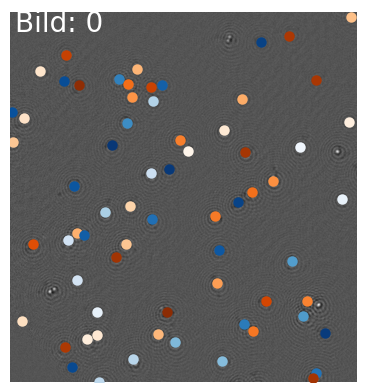

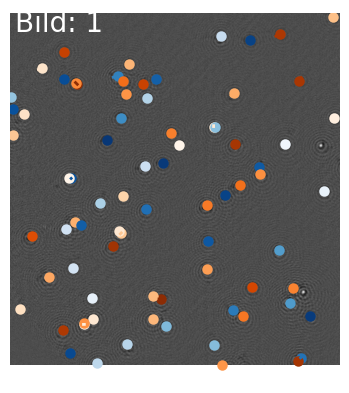

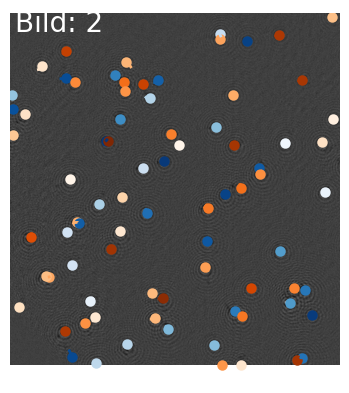

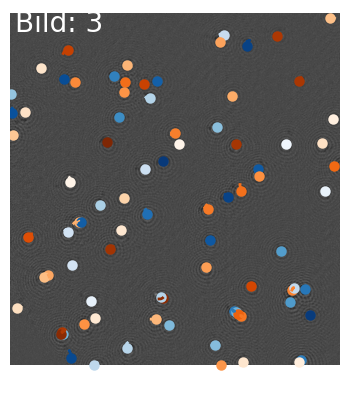

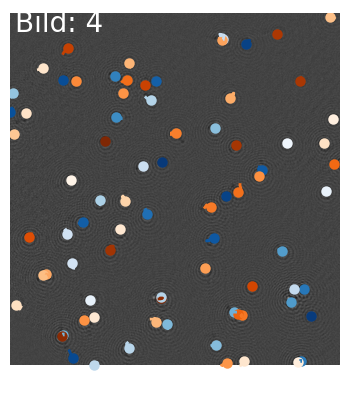

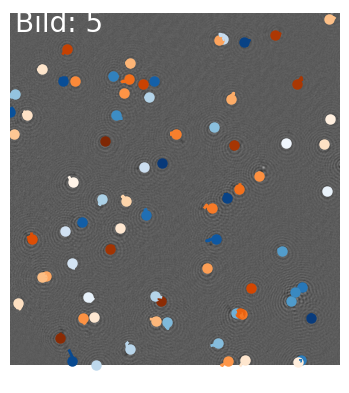

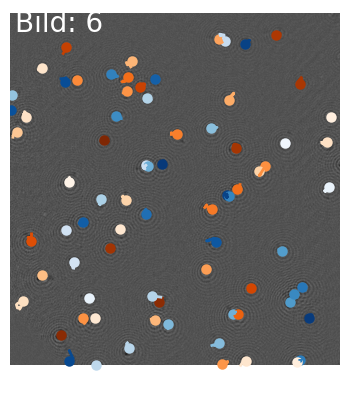

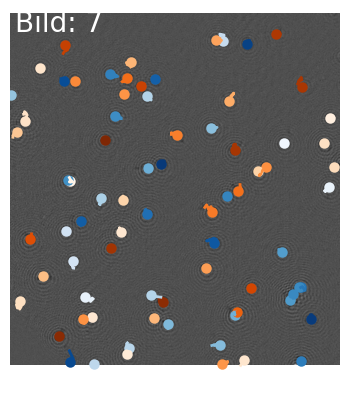

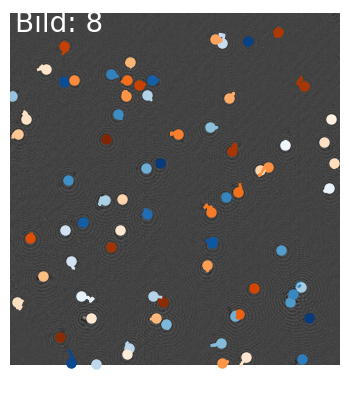

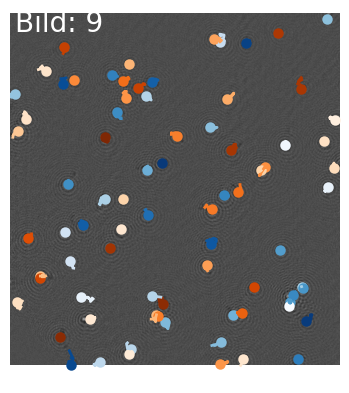

In [2]:
dataframe_path = r"C:\Users\kelme\Desktop\Deep_Learning\DeepLearningParticleTracking_BT\LodeSTAR\dataframes\Kanada_300nm_0-50.csv"
dataset_path = r"C:\Users\kelme\Desktop\Polystyrene_dia100nm_gap300nm_bgSubtracted.mat"

M = MAGIK(weights_path=r"C:\Users\kelme\Desktop\iSCAT_PartikelSp-rning\train_and_trace2d\utils\MAGIK.h5")
M.load_dataframe(dataframe_path)
M.set_dataset(Matlab(dataset_path))
M.detect()
#M.setup()

In [3]:
M.traj = [[t, c] for (t, c) in M.traj if len(t)>10]

kb = 1.380649*10**(-23)
T = 294
eta = 8.9*10**(-4)
r = 50*10**(-9)
D=kb*T/(6*np.pi*eta*r)

In [4]:
def Diffusiviteter(nodes = M.nodes, traj = M.traj, data_shape = M.data_shape, pixel_size = 65, framerate = 110):
    TAMSD_list=[]
    
    for (t, c) in traj:
        TAMSD=0
        Trajectory = t
        Nodes = nodes[Trajectory]
        for j in range(len(Nodes)-1):
            Tidssteg = Nodes[j+1][0]-Nodes[j][0]
            deltax = (Nodes[j][1]-Nodes[j+1][1])*data_shape[2]*pixel_size/Tidssteg
            deltay = (Nodes[j][2]-Nodes[j+1][2])*data_shape[1]*pixel_size/Tidssteg
            TAMSD += (deltax**2+deltay**2)/(len(Trajectory)-1)
        TAMSD_list.append(TAMSD)
    TAMSD_mu_list = np.array(TAMSD_list)*10**(-6) 
    
    delta_t = 1/framerate

    D_mu = TAMSD_mu_list/(4*delta_t)
    return D_mu

def Standardavvikelse(Diffusivitet):
    Mean = np.mean(Diffusivitet)
    sigma = np.sqrt(np.sum((Diffusivitet-Mean)**2)/(len(Diffusivitet)-1))
    return sigma

def Standardfel(Diffusivitet):
    return Standardavvikelse(Diffusivitet)/np.sqrt(len(Diffusivitet))

Medelvärde:  2.7440481927285227
Median:  4.851922915975301


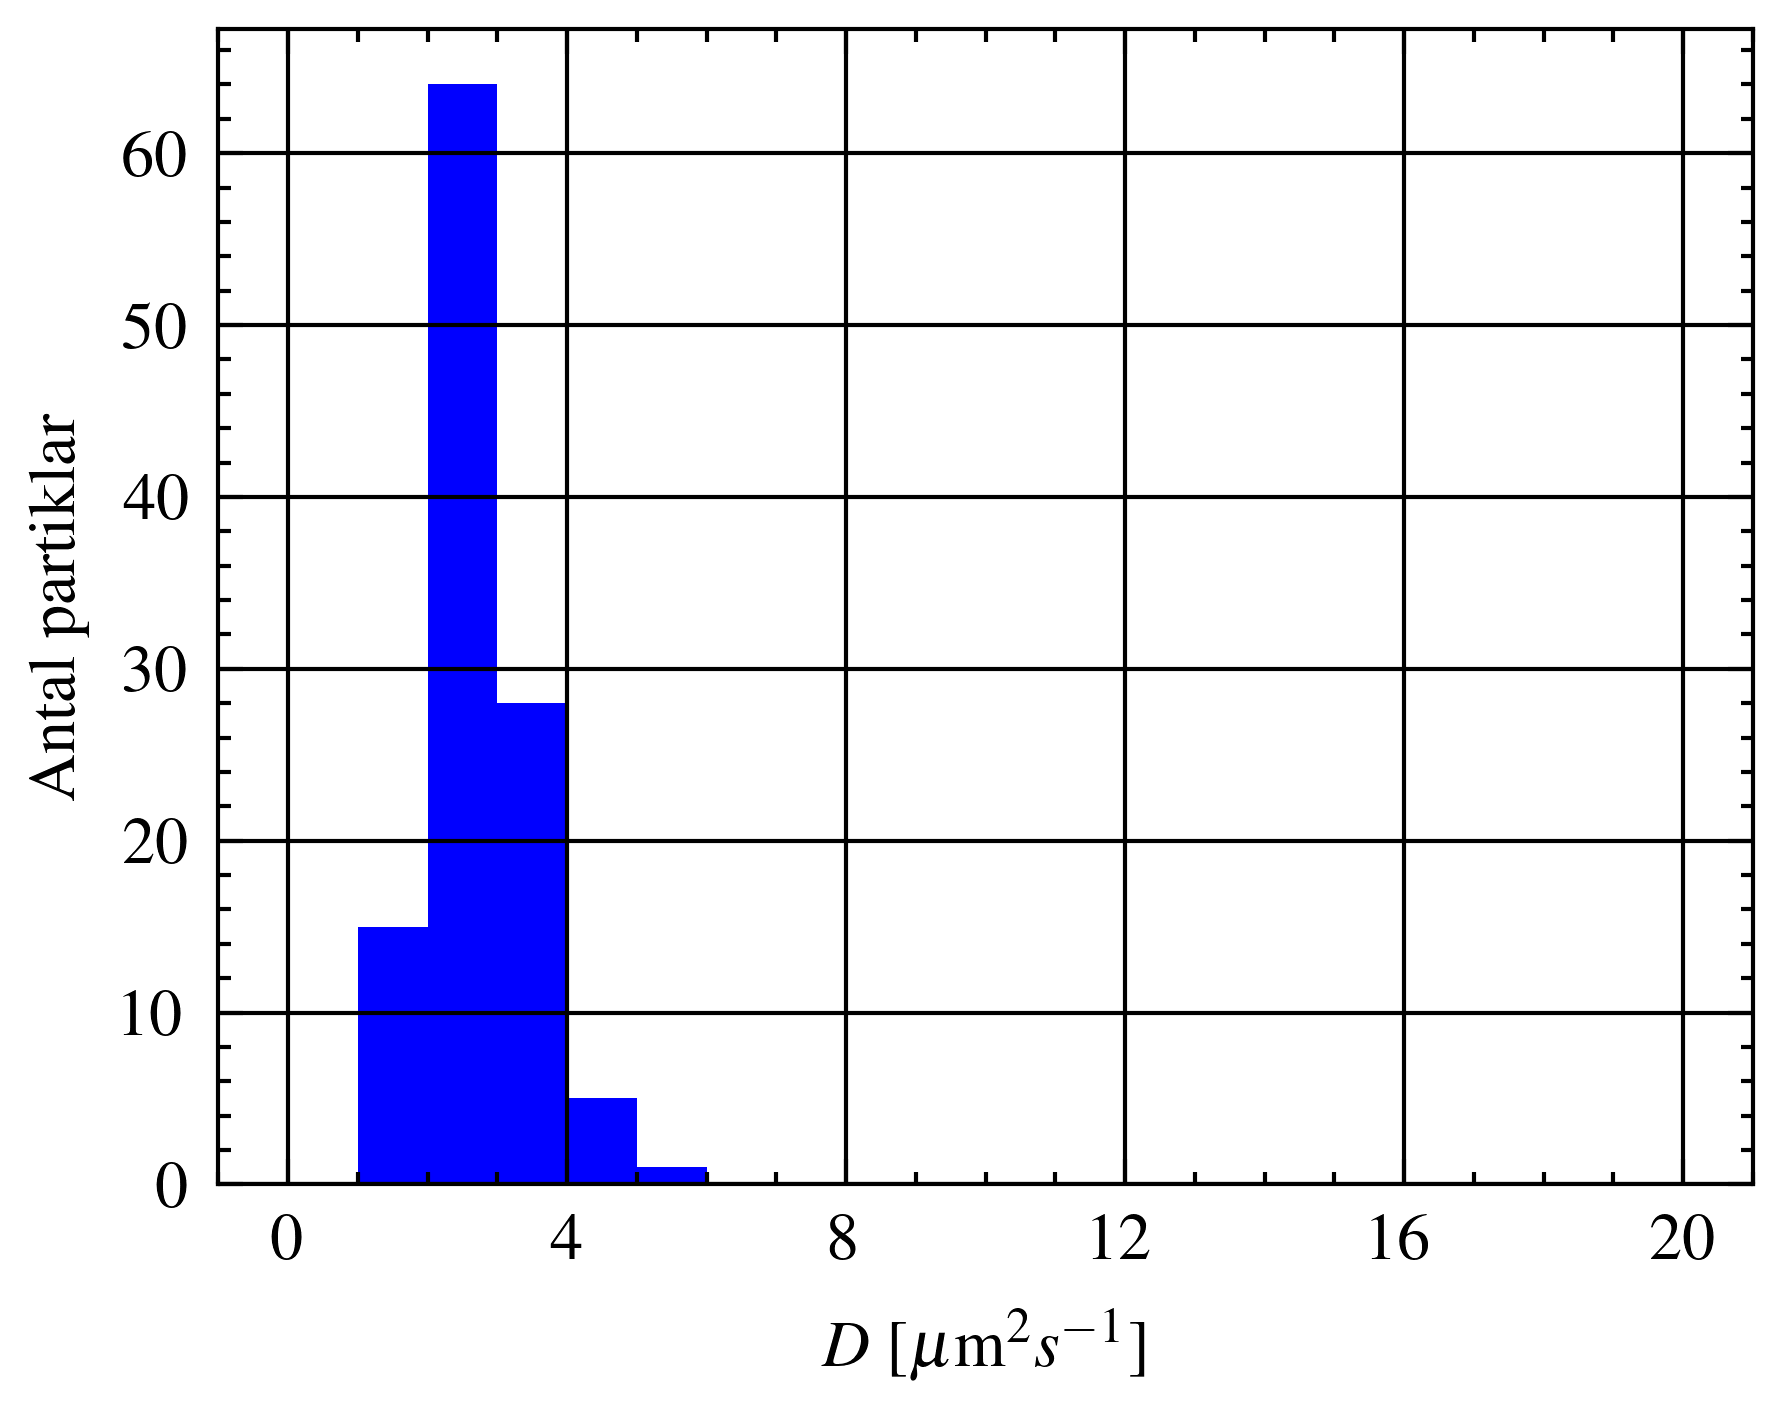

In [5]:
bins = 20
maxrange = 20
D_mu = Diffusiviteter()
print('Medelvärde: ', np.mean(D_mu))
print('Median: ', D_mu[int(len(D_mu)/2)])
xticks = np.linspace(0, maxrange, int(bins/4)+1)
with plt.style.context(["science", 'ieee']):
    plt.grid(color='black')
    plt.hist(D_mu, bins, color='blue', range = (0, maxrange))
    plt.xticks(xticks)
    
    plt.xlabel(r'$D$ [$\mu$m$^2 s^{-1}$]')
    plt.ylabel(r'Antal partiklar')

    plt.show()

In [6]:
def Kovarianser(nodes = M.nodes, traj = M.traj, data_shape = M.data_shape, pixel_size = 65, lagmax = 10):
    covx_matrix = []
    covy_matrix = []
    for (t, c) in traj:
        Nodes = nodes[t]
        covx_particle = []
        covy_particle = []
        for lag in range(lagmax):
            covx = np.array([])
            covy = np.array([])
            for j in range(len(Nodes)-1-lag):
                Tidsstegn = Nodes[j+1][0]-Nodes[j][0]
                Tidsstegnj = Nodes[j+1+lag][0]-Nodes[j+lag][0]

                Steg_xn  = (Nodes[j+1][1]-Nodes[j][1])/Tidsstegn
                Steg_xnj = (Nodes[j+1+lag][1]-Nodes[j+lag][1])/Tidsstegnj

                covx = np.append(covx, (Steg_xn*Steg_xnj)*(data_shape[2]*pixel_size*10**(-3))**2)#/(len(Nodes)-1-lag))

                Steg_yn  = (Nodes[j+1][2]-Nodes[j][2])/Tidsstegn
                Steg_ynj = (Nodes[j+1+lag][2]-Nodes[j+lag][2])/Tidsstegnj

                covy = np.append(covy, (Steg_yn*Steg_ynj)*(data_shape[1]*pixel_size*10**(-3))**2)#/(len(Nodes)-1-lag))
                

            covxapp = np.mean(covx)
            covyapp = np.mean(covy)

            covx_particle.append(covxapp)
            covy_particle.append(covyapp)
        covx_matrix.append(covx_particle)
        covy_matrix.append(covy_particle)
    
    Errorx = np.sqrt(np.sum((np.sum(covx_matrix, axis=0)/len(covx_matrix)-covx_matrix)**2, axis=0)/((len(covx_matrix)-1)*len(covx_matrix)))
    Errory = np.sqrt(np.sum((np.sum(covy_matrix, axis=0)/len(covy_matrix)-covy_matrix)**2, axis=0)/((len(covy_matrix)-1)*len(covx_matrix)))
    
    covxAvg = np.sum(covx_matrix, axis=0)/len(covx_matrix)
    covyAvg = np.sum(covy_matrix, axis=0)/len(covy_matrix)
    return covxAvg, covyAvg, Errorx, Errory

lagmax = 10
delta_t = 1/110
covxAvg, covyAvg, Errorx, Errory = Kovarianser(lagmax=lagmax)

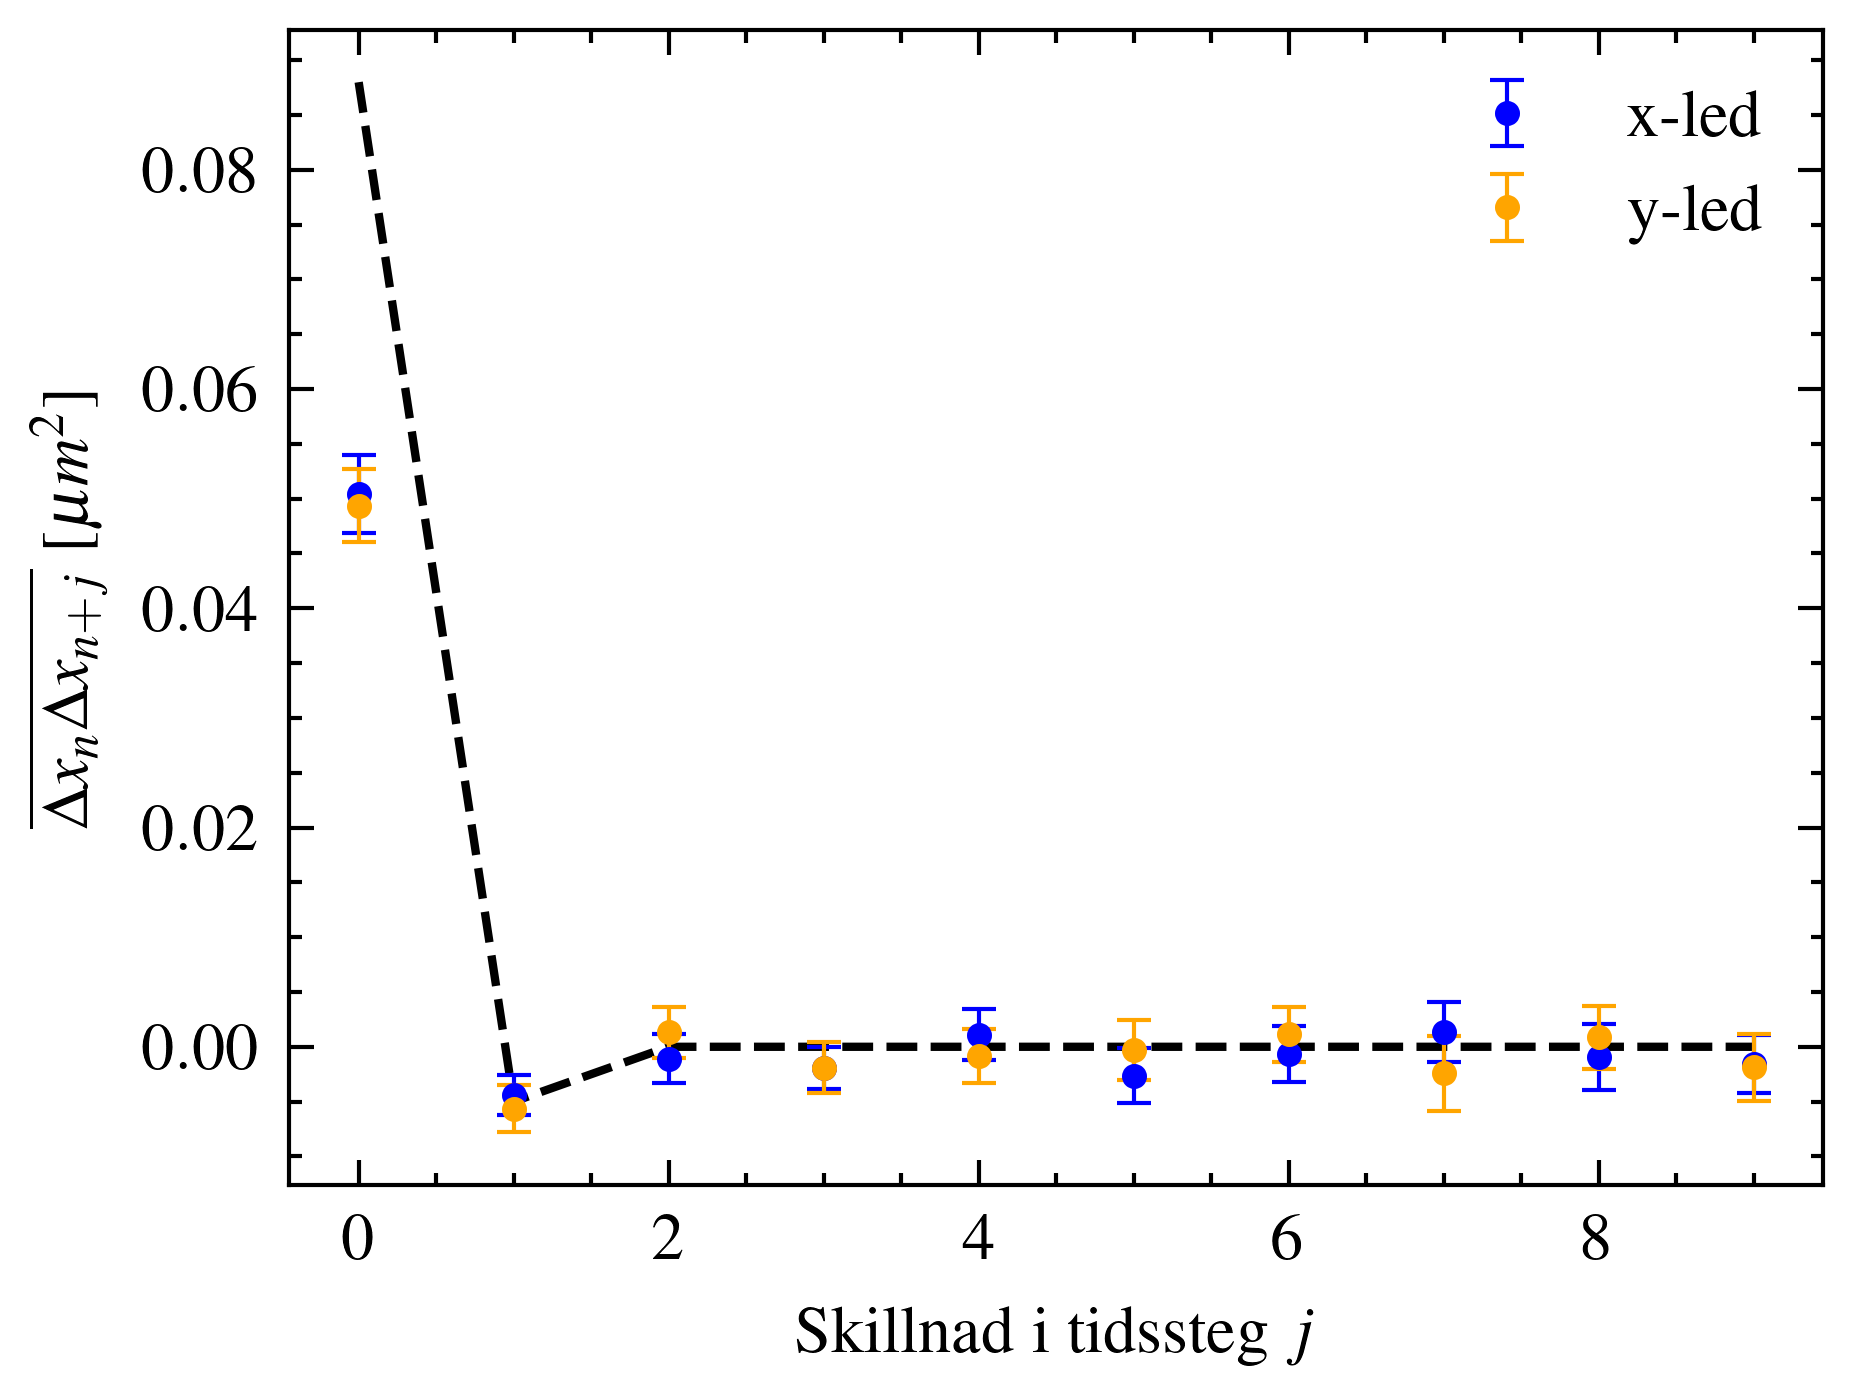

In [7]:

laglist = np.arange(0, lagmax, 1)
theory = np.zeros(len(laglist))
theory[0] = 2*D*delta_t*10**(12)
theory[1] = -0.005

with plt.style.context(["science", 'ieee']):
    
    plt.plot(laglist, theory, color='black', linestyle='--')

    plt.errorbar(laglist, covxAvg, Errorx*2, linestyle='', color='blue', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='x-led')
    
    plt.errorbar(laglist, covyAvg, Errory*2, linestyle='', color='orange', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='y-led')
    

    plt.xlabel(r'Skillnad i tidssteg $j$')
    plt.ylabel(r'$\overline{\Delta x_n \Delta x_{n+j}}$ [$\mu m^2$]')
    plt.legend()
    
    plt.show()
